In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "..")

# Or otherwise install trulens.
# !{sys.executable} -m pip install trulens

# Install transformers / huggingface.
!{sys.executable} -m pip install transformers pandas numpy

from IPython.display import display
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import re

from torch.utils.data import DataLoader
from pandas import Series

/home/piotrm/anaconda3/envs/python37_pytorch_cuda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Before getting started, familiarize yourself with the general Truera API as demonstrated in the [intro notebook using pytorch](intro_demo_pytorch.ipynb).

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    # device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

This model quantifies tweets (or really any text you give it) according to its sentiment: positive, negative, or neutral. Lets try it out on some examples.

In [159]:
tweets = pd.read_csv(
    Path("resources") / "training.1600000.processed.noemoticon.csv",
    encoding='ISO-8859-1',
    header=None,
    names=["polarity", "id", "timestamp", "query", "user", "text"]
)
tweets

,polarity,id,timestamp,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [143]:
def to_team(team):
    """Replaces all instances of ':team:' with the given `team` in the given list of tweets."""

    def f(strings):
        if isinstance(strings, pd.Series):
            return strings.map(subst(":team:", team))
        if isinstance(strings, np.ndarray):
            return np.vectorize(subst(":team:", team))(strings)
        raise ValueError("I don't know")
    return f

def word_pattern(word):
    """Create a pattern that matches the given `word` as long as it is not immediately next to an alpha-numeric character."""
    return "(?<!\w)" + re.escape(word) + "(?!\w)"

def subst(thing_from: str, thing_to: str):
    pat = re.compile(word_pattern(thing_from), re.IGNORECASE)
    def f(context: str):
        return pat.sub(thing_to, context)
    return f

def extract_teams(teams):
    """Create a method that extracts tweets that contain mentions of any of the terms in the given `teams`."""

    pattern = '|'.join(map(word_pattern, teams))
    reg = re.compile(pattern, re.IGNORECASE)

    def f(text):
        indices = text.str.contains(reg)
        ret = text[indices]

        for team in teams:
            ret = ret.map(subst(team, ":team:"))

        return ret

    return f

team_tweets = extract_teams(
    # ["diamondbacks", "braves", "orioles", "redsox", "red sox", "cubs", "whitesox", "white sox", "reds", "guardians", "rockies", "tigers", "astros", "royals", "dodgers", "marlins", "brewers", "twins", "mets", "yankees", "athletics", "phillies", "pirates", "padres", "giants", "mariners", "cardinals", "rays", "rangers", "jays", "nationals"]
    ['redsox', 'red sox', 'yankees'],
    )(tweets['text'])

In [164]:
print(len(team_tweets))

teams = ['redsox', 'yankees']
tweets_for_team = {team: to_team(team)(team_tweets) for team in teams}

for team in teams:
    print(team)
    for tweet in tweets_for_team[team][0:10]:
        print("\t", tweet)

373
redsox
	 Why oh why was the redsox game rained out? I was so looking forward to opening day 
	 YAY FOR BASEBALL SEASON! boo to redsox losing their first game 
	 going to walk my dogs and shower before bed.   sad the redsox lost the first game monday too!  boooo 
	 ughh can't find my redsox hat, gotta wear this creepy nick pirro version 
	 No redsox opening game for me.  Conflicts will prevent me from going to the rescheduled game.
	 Noooooo the orioles beat the redsox 10-5  need to get to bmore to see derek jeter!!!!
	 @jutecht btw...loved your baseball post...this is definitely best time of year...was disappointed redsox opener was rained out... 
	 for those of you thinking i hate the redsox - i dont. i'm a redsox fan.  and losing to the orioles no less 
	 @MCHammer the redsox arent looking too impressive  Spent all that money for an allstar team, they shouldnt lose A game!!!
	 @RiverAveBlues The Indians are looking like the 27 redsox. 
yankees
	 Why oh why was the yankees game ra

In [165]:
def eval_batched(data: Series, batch_size=16):
    """Evaluate the model `task.model` on given `data` tokenized by `task.tokenizer` in a set of batches. Return the logits."""
    sentences = DataLoader(data.to_numpy(), batch_size=batch_size)

    all_logits = []

    for batch in sentences:
        tokens = task.tokenizer(batch, padding=True, return_tensors='pt').to(task.device)
        logits = task.model(**tokens)['logits'].detach().to('cpu')
        del tokens
        all_logits += logits

    return np.stack(list(map(torch.Tensor.numpy, all_logits)))

logits_for_team = {team: eval_batched(sentences) for team, sentences in tweets_for_team.items()}

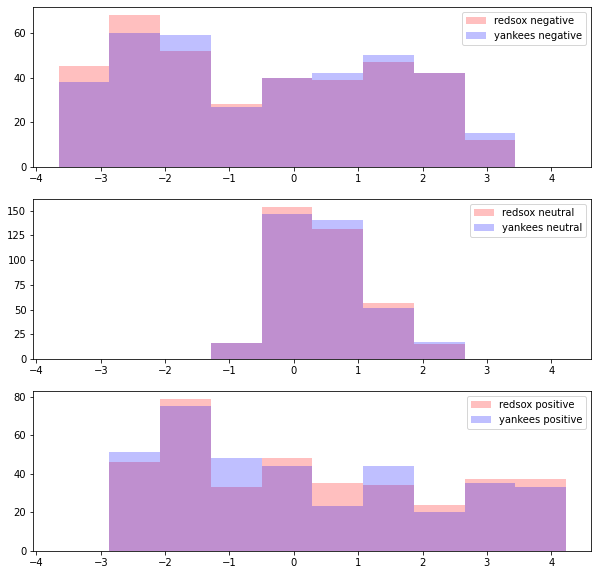

In [167]:
amin = min(logits.min() for logits in logits_for_team.values())
amax = max(logits.max() for logits in logits_for_team.values())

colors = {teams[0]: 'red', teams[1]: 'blue'}

# Create a figure showing the histogram of logits for each of the three classes for all of the teams in `teams`.

fig, axs = plt.subplots(3,1, figsize=(10,10))
for idx, label in zip([task.NEGATIVE,task.NEUTRAL,task.POSITIVE], task.labels):
    for team, logits in logits_for_team.items():
        axs[idx].hist(logits[:, idx], bins=10, alpha=0.25, label=f"{team} {label}", color=colors[team], range=(amin, amax))
    axs[idx].legend()

In [89]:
sort_idx = np.argsort(abs(outs_reds - outs_yank).sum(axis=1))[::-1]

In [90]:
teams_np = teams.to_numpy()

for idx in sort_idx[0:10]:
    neutral = teams_np[idx]
    out_reds = outs_reds[idx]
    out_yank = outs_yank[idx]

    print(idx, neutral, out_reds, out_yank)

2327 @kevinrose only very brave people milk :team:  [-1.6999707   0.85507244  1.0117046 ] [ 0.24272746  0.6633106  -0.849317  ]
4084 @saabmagalona http://twitpic.com/6lf73 - you look like :team:  [-2.6222086  1.3609225  1.6356875] [-0.6952697   1.077642   -0.10690404]
3377 :team: killing the :team:  payback!!! [-1.0774279   0.61354315  0.7087532 ] [ 0.81295    0.4724068 -1.103123 ]
1677 :team: are really playing  [-2.1432636  0.523304   2.0321195] [-0.47701013  0.6932248   0.14570668]
4347 @pmdeleon you and Selena are like :team:.  Haha [-1.8814346   1.2910842   0.85185814] [-0.15441222  0.8987431  -0.53634393]
4167 Now f:team: listening to when you me in the eyes  [-2.2089572   1.9524648   0.45410588] [-0.5272308  1.4249909 -0.7299234]
4310 @tobascodagama Hey me too! We're computer :team:ies.  [-2.5484004  1.4538283  1.4469616] [-0.9540759   0.969785    0.28349736]
1077 @ClarenceHill Your :team: beat my :team:.  [-0.94331634  0.7934554   0.3659697 ] [ 0.6076243  0.7082474 -1.1555302]


In [97]:
interesting = teams_np[sort_idx[0:10]]

ins = np.concatenate(
    list(zip(to_team("red sox")(interesting), to_team("yankees")(interesting)))
)

outs = retrieve(task.model(**tokenize(list(ins))))

In [99]:
for input, output in zip(ins, outs):
    print(input, output)

@kevinrose only very brave people milk red sox  tensor([-1.3698,  0.8484,  0.6590])
@kevinrose only very brave people milk yankees  tensor([ 0.2426,  0.6633, -0.8493])
@saabmagalona http://twitpic.com/6lf73 - you look like red sox  tensor([-2.7711,  1.3130,  1.8328])
@saabmagalona http://twitpic.com/6lf73 - you look like yankees  tensor([-0.6953,  1.0776, -0.1069])
red sox killing the red sox  payback!!! tensor([-0.8718,  0.6505,  0.4067])
yankees killing the yankees  payback!!! tensor([ 0.8130,  0.4724, -1.1031])
red sox are really playing  tensor([-2.0321,  0.7105,  1.6978])
yankees are really playing  tensor([-0.4770,  0.6932,  0.1457])
@pmdeleon you and Selena are like red sox.  Haha tensor([-1.8309,  1.2672,  0.8636])
@pmdeleon you and Selena are like yankees.  Haha tensor([-0.1548,  0.8989, -0.5363])
Now fred sox listening to when you me in the eyes  tensor([-2.1722,  1.9765,  0.3560])
Now fyankees listening to when you me in the eyes  tensor([-0.5265,  1.4245, -0.7302])
@tobasco

Evaluating huggingface models is straight-forward if we use the structure produced by the tokenizer.

# Model Wrapper

As in the prior notebooks, we need to wrap the pytorch model with the appropriate Trulens functionality. Here we specify the maximum input size (in terms of tokens) each tweet may have.

In [ ]:
from trulens.nn.models import get_model_wrapper
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients, InputAttribution
from trulens.nn.attribution import Cut, OutputCut
from trulens.utils.typing import ModelInputs
from trulens.nn.distributions import GaussianDoi

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

# Attributions

Applying integrated gradents to the sentiment model is similar as in the prior notebooks except special considerations need to be made for the cuts used as the targets of the attribution (i.e. what do we want to assign importance to). As you may have noted above, the model takes as input integer indexes associated with tokens. As we cannot take gradient with respect to these, we use an alternative: the embedding representation of those same inputs. To instantiate trulens with this regard, we need to find inspect the layer names inside our model:

## Parameters

Above, `roberta_embeddings_word_embeddings` is the layer that produces a continuous representation of each input token so we will use that layer as the one defining the **distribution of interest**. While most neural NLP models contain a token embedding, the layer name will differ.

The second thing to note is the form of model outputs. Specifically, outputs are structures which contain a 'logits' attribute that stores the model scores.

Putting these things together, we instantiate `IntegratedGradients` to attribute each embedding dimension to the maximum class (i.e. the predicted class).

In [ ]:
# Alternatively we can look at a particular class:

infl_positive = IntegratedGradients(
    model = task.wrapper,
    resolution=10,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)


# Alternatively we can look at a particular class:


infl_positive = InputAttribution(
    model = task.wrapper,
    doi='point',
    # doi=GaussianDoi(var=0.001, resolution=10, cut=Cut('roberta_embeddings_word_embeddings')),
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)


Getting attributions uses the same call as model evaluation.

A listing as above is not very readable so Trulens comes with some utilities to present token influences a bit more concisely. First we need to set up a few parameters to make use of it:

In [ ]:
from trulens.visualizations import NLP



V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=lambda sentences: ModelInputs(kwargs=task.tokenizer(sentences, padding=True, return_tensors='pt')).map(lambda t: t.to(task.device)),
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x.kwargs['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

print("QOI = POSITIVE")
display(V.token_attribution(pairs[0:20], infl_positive))

# Baselines

We see in the above results that special tokens such as the sentence end **&lt;/s&gt;** contributes are found to contribute a lot to the model outputs. While this may be useful in some contexts, we are more interested in the contributions of the actual words in these sentences. To focus on the words more, we need to adjust the **baseline** used in the integrated gradients computation. By default in the instantiation so far, the baseline for each token is a zero vector of the same shape as its embedding. By making the basaeline be identicaly to the explained instances on special tokens, we can rid their impact from our measurement. Trulens provides a utility for this purpose in terms of `token_baseline` which constructs for you the methods to compute the appropriate baseline. 

In [ ]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.sep_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

We can now inspect the baselines on some example sentences. The first method returned by `token_baseline` gives us token ids to inspect while the second gives us the embeddings of the baseline which we will pass to the attributions method.

In [ ]:
infl_positive_baseline = IntegratedGradients(
    model = task.wrapper,
    resolution=50,
    baseline = inputs_baseline_embeddings,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

print("QOI = POSITIVE WITH BASELINE")
display(V.token_attribution(sentences, infl_positive_baseline))

As we see, the baseline eliminated the measurement of contribution of the special tokens.